# NLP Project

In this project, you are expected to perform NLP on an online dataset that you will obtain from an API or scraping.

This is an open-ended project, and you can be creative!

### Requirements:
- Obtain data from an API or web-scraping. No premade datasets from Kaggle!
- You are epxected to work on some form of **text data**.
- Your goal is to uncover underlying clusters (social communities, market patters) etc., using unsupervised learning.
- You can use any method; clustering, sentiment analysis, dimensionality reduction, pretrained models, word-embeddings, network embeddings, etc.
- Create a visualization in 2d or 3d of the data with the clusters you found tagged. See reddit example below.
- Analyze the produced clusters and use them to provide a short explanation of what you found.

Reddit example visualization:

![](reddit.png)

**You don't have to do it at a large scale**

The data for these sort of projects can run very large if you let them, making the enterprise difficult.

You can limit yourself to samples of the communities you're looking at rather than the entire thing.

Please focus on exploring multiple techniques, understanding which ones would be most applicable, and interpreting the final results.

### Good Luck!

In [474]:
# Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Web Scraping

In [423]:
def scrape_books_to_csv(pages=20, output_file='books_data.csv'):
    base_url = "https://books.toscrape.com/catalogue/page-{}.html"
    all_books = []    
    for page in tqdm(range(1, pages+1), desc="Scraping pages"):
        try:
            response = requests.get(base_url.format(page))
            soup = BeautifulSoup(response.text, 'html.parser')            
            books = soup.find_all('article', class_='product_pod')
            for book in books:
                title = book.h3.a['title']
                price = book.find('p', class_='price_color').text
                rating = book.p['class'][1]  # One of 'One', 'Two', ..., 'Five'
                availability = book.find('p', class_='instock').text.strip()                
                # Get book details
                book_url = "https://books.toscrape.com/catalogue/" + book.h3.a['href']
                book_response = requests.get(book_url)
                book_soup = BeautifulSoup(book_response.text, 'html.parser')                
                description = book_soup.find('meta', attrs={'name': 'description'})['content'].strip()
                category = book_soup.find('ul', class_='breadcrumb').find_all('li')[2].text.strip()                
                all_books.append({
                    'title': title,
                    'price': price,
                    'rating': rating,
                    'availability': availability,
                    'category': category,
                    'description': description})                
        except Exception as e:
            print(f"Error scraping page {page}: {e}")    
    df = pd.DataFrame(all_books)
    df.to_csv(output_file, index=False)
    print(f"\nSuccessfully scraped {len(df)} books to {output_file}")
    return df

In [425]:
# Run the scraper
books_df = scrape_books_to_csv(pages=20)

Scraping pages: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


Successfully scraped 400 books to books_data.csv


In [426]:
# Read CSV
df = pd.read_csv('books_data.csv')

In [427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         400 non-null    object
 1   price         400 non-null    object
 2   rating        400 non-null    object
 3   availability  400 non-null    object
 4   category      400 non-null    object
 5   description   399 non-null    object
dtypes: object(6)
memory usage: 18.9+ KB


In [428]:
df.head()

,title,price,rating,availability,category,description
0,A Light in the Attic,Â£51.77,Three,In stock,Poetry,It's hard to imagine a world without A Light i...
1,Tipping the Velvet,Â£53.74,One,In stock,Historical Fiction,"""Erotic and absorbing...Written with starling ..."
2,Soumission,Â£50.10,One,In stock,Fiction,"Dans une France assez proche de la nÃ´tre, un ..."
3,Sharp Objects,Â£47.82,Four,In stock,Mystery,"WICKED above her hipbone, GIRL across her hear..."
4,Sapiens: A Brief History of Humankind,Â£54.23,Five,In stock,History,From a renowned historian comes a groundbreaki...


In [429]:
df.sample(20)

,title,price,rating,availability,category,description
306,Far & Away: Places on the Brink of Change: Sev...,Â£15.06,Four,In stock,Nonfiction,From the winner of the National Book Award and...
185,Large Print Heart of the Pride,Â£19.15,Two,In stock,Default,Paranormal Romance Erotic Werelion Thrill Ride...
197,Done Rubbed Out (Reightman & Bailey #1),Â£37.72,Five,In stock,Default,In this first book of the Reightman & Bailey S...
136,The Wedding Dress,Â£24.12,One,In stock,Romance,"Four brides. One Dress.A tale of faith, redemp..."
84,Patience,Â£10.16,Three,In stock,Sequential Art,Patience is a psychedelic science-fiction love...
294,"It's All Easy: Healthy, Delicious Weeknight Me...",Â£19.55,One,In stock,Food and Drink,For fans of It's All Good-or just delicious fo...
58,The Past Never Ends,Â£56.50,Four,In stock,Mystery,"A simple task, Attorney Chester Morgan thinks...."
314,Doctor Sleep (The Shining #2),Â£40.12,Two,In stock,Horror,Stephen King returns to the characters and ter...
383,Equal Is Unfair: America's Misguided Fight Aga...,Â£56.86,One,In stock,Politics,Weâve all heard that the American Dream is v...
312,"Eat Fat, Get Thin",Â£54.07,Two,In stock,Health,Originally released by Hachettee Audio A2015.


## Data Preprocessing

In [431]:
# Remove row with missing description
df=df.dropna()

In [432]:
# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 0 to 399
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         399 non-null    object
 1   price         399 non-null    object
 2   rating        399 non-null    object
 3   availability  399 non-null    object
 4   category      399 non-null    object
 5   description   399 non-null    object
dtypes: object(6)
memory usage: 21.8+ KB


In [433]:
# Define description as str
df['description'] = df['description'].astype(str)

In [434]:
# Only keep category and description
df = df[['category','description']]

In [435]:
words = df['description'].str.split()
words = pd.DataFrame(words.tolist())
words.head()

,0,1,2,3,4,5,6,7,8,9,...,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123
0,It's,hard,to,imagine,a,world,without,A,Light,in,...,None,None,None,None,None,None,None,None,None,None
1,"""Erotic",and,absorbing...Written,with,starling,"power.""--""The",New,York,Times,Book,...,None,None,None,None,None,None,None,None,None,None
2,Dans,une,France,assez,proche,de,la,"nÃ´tre,",un,homme,...,None,None,None,None,None,None,None,None,None,None
3,WICKED,above,her,"hipbone,",GIRL,across,her,heart,Words,are,...,None,None,None,None,None,None,None,None,None,None
4,From,a,renowned,historian,comes,a,groundbreaking,narrative,of,humanityâs,...,None,None,None,None,None,None,None,None,None,None


In [436]:
# Remove stop words and unecessary characters
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k),v) for k, v in replaceDict.items())
pattern = re.compile('|'.join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['description'].str.replace(pattern, replacer, regex=True).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155
0,it,s,hard,to,imagine,a,world,without,a,light,...,None,None,None,None,None,None,None,None,None,None
1,erotic,and,absorbing,written,with,starling,power,the,new,york,...,None,None,None,None,None,None,None,None,None,None
2,dans,une,france,assez,proche,de,la,nã´tre,un,homme,...,None,None,None,None,None,None,None,None,None,None
3,wicked,above,her,hipbone,girl,across,her,heart,words,are,...,None,None,None,None,None,None,None,None,None,None
4,from,a,renowned,historian,comes,a,groundbreaking,narrative,of,humanityâs,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,a,rocker,gets,a,taste,of,unexpected,passion,in,the,...,None,None,None,None,None,None,None,None,None,None
395,a,page,turning,debut,in,the,tradition,of,michael,crichton,...,None,None,None,None,None,None,None,None,None,None
396,one,of,only,two,patron,saints,of,italy,the,other,...,None,None,None,None,None,None,None,None,None,None
397,a,beautiful,violinist,is,haunted,by,a,very,old,piece,...,None,None,None,None,None,None,None,None,None,None


In [437]:
import gensim.downloader as model_api
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [438]:
# Word vector
def get_word_vector(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return np.zeros(word_vectors.vector_size)

In [464]:
# Mapping
def map_review_to_vector(description):
    return np.sum([get_word_vector(word) for word in description if pd.notna(word)], axis=0)

In [466]:
# Apply the mapping function to each description
emb = pd.DataFrame(words.apply(map_review_to_vector, axis=1).tolist())
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,28.441889,59.044169,-21.668224,-31.006528,66.229684,25.792585,-55.477866,-40.746727,-35.049340,38.852186,...,11.577699,8.917570,-7.149795,17.419295,8.514514,27.133400,2.605796,-39.765514,-22.247192,-0.141740
1,23.818220,63.338989,-41.666351,-5.168194,58.156376,29.681255,-83.762665,-16.236328,-19.871815,-7.660953,...,-11.738602,21.684929,-21.755394,-5.614970,-8.408254,4.754866,-11.991362,-70.415527,-12.322545,-12.177896
2,42.335133,56.559471,-73.549216,-38.001446,-80.056602,-76.023866,44.386107,-5.411955,-34.816223,6.922776,...,59.292445,-49.329430,54.402972,-63.810575,-34.631571,-59.571734,-17.164729,-4.963435,67.980985,53.058172
3,76.540483,71.883486,-47.673259,-72.624915,83.597392,93.410033,-111.795186,26.611518,-31.707399,-3.081345,...,-39.396349,21.173818,-3.123138,-8.723885,10.371297,-10.622409,16.770695,-90.594776,-4.777058,-40.475784
4,106.988698,65.295034,-34.044544,-23.485978,102.032454,68.455091,-100.837959,-95.785550,-22.189744,0.765487,...,-62.669129,-4.117570,44.067574,41.416307,-19.585685,56.246980,-11.615405,5.960631,-59.622744,-33.658109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,31.721226,47.361979,-38.131524,-25.030918,77.865968,44.709394,-100.948676,5.200948,-34.940677,23.442166,...,-15.537087,27.446822,-32.738519,8.826153,1.062987,10.446233,-13.947801,-48.245880,-19.284071,4.280602
395,88.377870,64.548920,-25.099389,-20.964570,111.710213,70.586884,-111.407712,-35.196699,-11.327524,-16.529015,...,-39.503197,10.944992,-13.579514,17.113370,-12.360266,21.772614,-2.134432,-75.366392,-10.729756,-71.977817
396,99.291466,90.211834,-86.296308,-79.476552,120.746983,70.433520,-111.345160,-22.897728,-58.670923,-23.364654,...,-47.590187,24.114280,-13.469866,8.290846,-23.714818,62.866246,-59.618734,-91.727755,-22.436392,-84.757516
397,46.869475,41.838425,-50.855126,-23.317720,73.495480,52.192593,-66.142000,4.159423,-33.950032,12.575770,...,-17.518484,27.735377,-4.214289,-12.518733,2.875331,13.996560,-5.746444,-67.417928,-2.005639,-12.931626


In [468]:
from sklearn.model_selection import train_test_split
y = df['category']
X = emb

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [470]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

C:\Users\ladhi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [472]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                     precision    recall  f1-score   support

     Add a comment       0.10      0.25      0.14         4
         Biography       0.00      0.00      0.00         1
          Business       0.00      0.00      0.00         1
         Childrens       0.00      0.00      0.00         6
      Contemporary       0.00      0.00      0.00         1
             Crime       0.00      0.00      0.00         1
           Default       0.30      0.25      0.27        12
           Fantasy       0.00      0.00      0.00         5
           Fiction       0.23      0.50      0.32         6
    Food and Drink       1.00      0.75      0.86         4
            Health       0.00      0.00      0.00         0
Historical Fiction       0.00      0.00      0.00         2
           History       0.50      1.00      0.67         1
            Horror       0.00      0.00      0.00         1
             Humor       0.00      0.00      0.00         0
             Mu

C:\Users\ladhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ladhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ladhi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ladhi\anaconda3\Lib\site-packages\sklea

C:\Users\ladhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


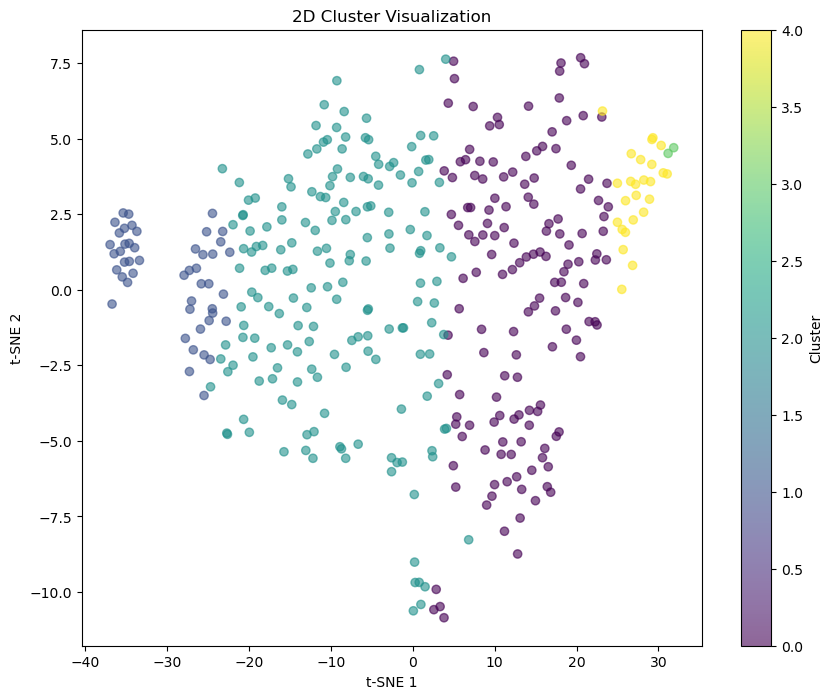

In [444]:
# 2. Dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
# Convert df to array
emb_2d = tsne.fit_transform(emb.values)  

# 3. Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(emb.values)

# 4. Visualization
plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('2D Cluster Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')
plt.show()